# face recognition on olivetti  
olivetti dataset:  
* There are **10** different image of each of **40** distinct people
* There are **400** face images in the dataset
* Face images were taken at different times, variying ligthing, facial express and facial detail
* All face images have black background
* The images are **gray** level
* Size of each image is **64x64**
* Image pixel values were scaled to **[0, 1]** interval
* Names of 40 people were encoded to an integer **from 0 to 39**

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score,classification_report,precision_recall_curve,average_precision_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score,LeaveOneOut,GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import  OneVsRestClassifier

import warnings
warnings.filterwarnings('ignore')

## 1.读取数据集并了解数据信息


In [4]:
data=np.load('./olivetti_faces.npy')
target=np.load('./olivetti_faces_target.npy')

print('人脸数据维度：',data.shape)
print('人脸标签：',np.unique(target))

人脸数据维度： (400, 64, 64)
人脸标签： [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


## 2.人脸数据可视化

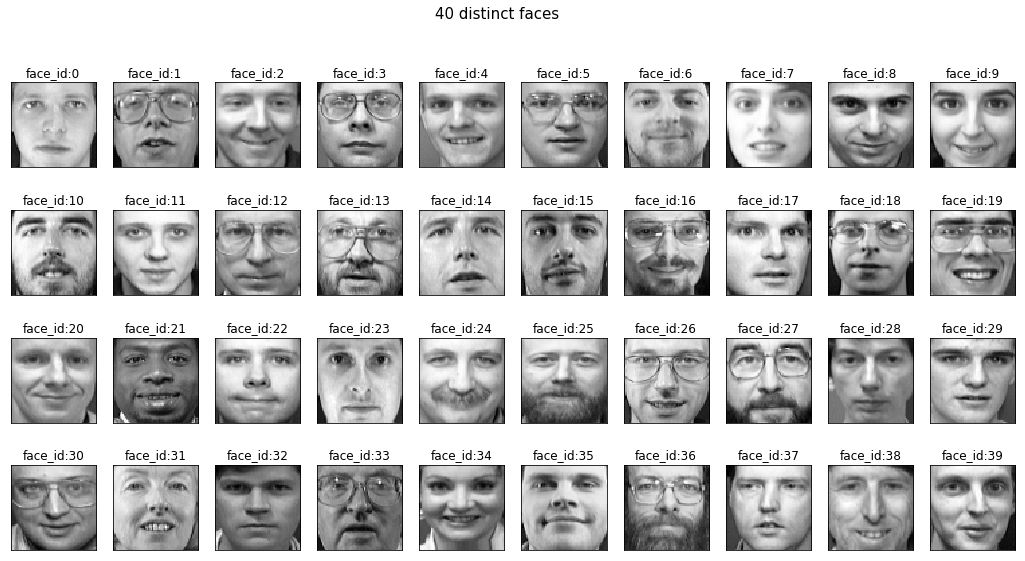

In [5]:
# 显示40种不同类别的人脸数据
def show_40_distinct_faces():
    fig,axes=plt.subplots(4,10,figsize=(18,9))
    axes=axes.flatten()
    
    for i in range(40):
        img=data[i*10]
        axes[i].imshow(img,cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title('face_id:{}'.format(i))
    plt.suptitle('40 distinct faces',fontsize=15)

show_40_distinct_faces()       

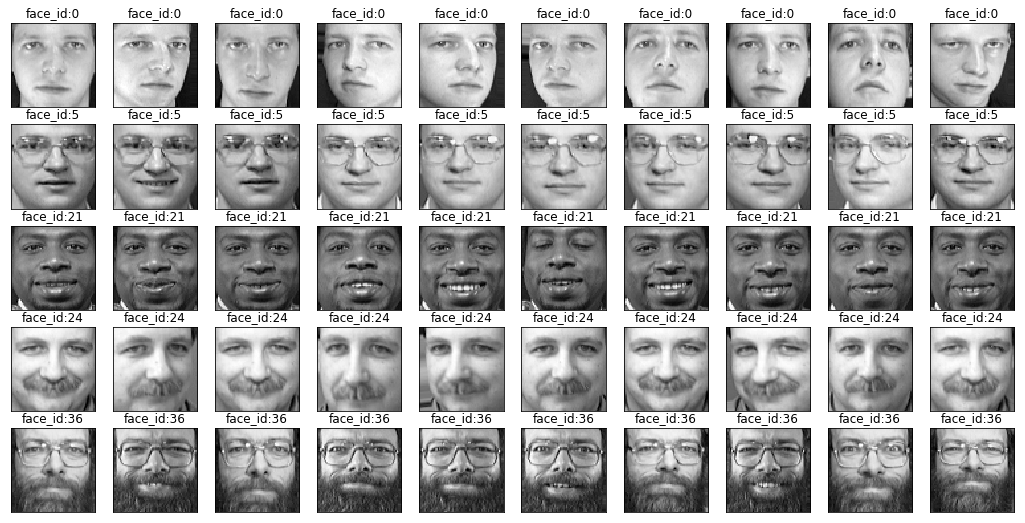

In [6]:
# 显示指定类别的所有人脸数据
def show_10_faces_on_each_subject(cat):
    fig,axes=plt.subplots(len(cat),10,figsize=(18,9))
    
    for i,cls in enumerate(cat):
        for j in range(10):
            img=data[cls*10+j]
            axes[i][j].imshow(img,cmap='gray')
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
            axes[i][j].set_title('face_id:{}'.format(cls))
show_10_faces_on_each_subject([0,5,21,24,36])

## 3.数据处理及模型训练

划分数据集

In [7]:
# 转为二维数据
data_=data.reshape(data.shape[0],-1)

# 设置stratify，使得划分比例等于样本类别比例
x_train,x_test,y_train,y_test=train_test_split(data_,target,test_size=0.3,stratify=target,random_state=78)
df=pd.DataFrame({'subject_id':y_train})
df['subject_id'].value_counts()

39    7
38    7
17    7
16    7
15    7
14    7
13    7
12    7
11    7
10    7
9     7
8     7
7     7
6     7
5     7
4     7
3     7
2     7
1     7
18    7
19    7
20    7
30    7
37    7
36    7
35    7
34    7
33    7
32    7
31    7
29    7
21    7
28    7
27    7
26    7
25    7
24    7
23    7
22    7
0     7
Name: subject_id, dtype: int64

PCA降维处理

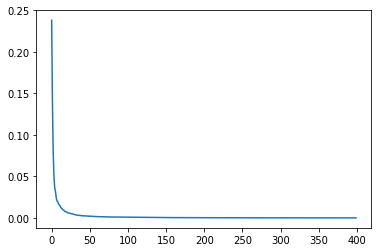

In [8]:
# 选择合适的降维特征数
pca=PCA(random_state=78)
pca.fit(data_)
plt.plot(pca.explained_variance_ratio_)
plt.show()

#保证占比0.95以上
select_n_conponents=np.where(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0][0]

对比多个模型

In [9]:
pca=PCA(n_components=select_n_conponents,whiten=True,random_state=78)
x_train_pca=pca.fit_transform(x_train)
x_test_pca=pca.transform(x_test)

models=[]
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(("LR",LogisticRegression()))
models.append(("KNN",KNeighborsClassifier(n_neighbors=5)))
models.append(("DT",DecisionTreeClassifier()))
models.append(("SVM",SVC()))

for name, model in models: 
    clf=model
    clf.fit(x_train_pca,y_train)
    y_pred=clf.predict(x_test_pca)

    print(10*"=","{} Result".format(name).upper(),10*"=")
    print("Accuracy score:{:0.4f}".format(accuracy_score(y_test, y_pred)))

========== LDA RESULT ==========
Accuracy score:0.9583
========== LR RESULT ==========
Accuracy score:0.9500
========== KNN RESULT ==========
Accuracy score:0.6000
========== DT RESULT ==========
Accuracy score:0.5000
========== SVM RESULT ==========
Accuracy score:0.9583


由上述计算结果可知，LDA和LR、SVM的效果是不错的。  
接下来使用交叉验证进一步测试。

In [10]:
pca=PCA(n_components=select_n_conponents,whiten=True,random_state=78)
data_pca=pca.fit_transform(data_)
kfold=KFold(n_splits=5,shuffle=True,random_state=78)

for name, model in models:
    clf=model
    score=cross_val_score(clf,data_pca,target,cv=kfold)
    print(10*"=","{} Result".format(name).upper(),10*"=")
    print("cross val score mean:{:0.4f}".format(score.mean()))

========== LDA RESULT ==========
cross val score mean:0.9775
========== LR RESULT ==========
cross val score mean:0.9425
========== KNN RESULT ==========
cross val score mean:0.5750
========== DT RESULT ==========
cross val score mean:0.4175
========== SVM RESULT ==========
cross val score mean:0.8025


由上述交叉验证结果，可以发现LDA和LR的效果依然很不错。接下来重点研究该两种模型。



使用Leave one out划分数据方法（之前是KFold），是因为每个类别的样本只有10个，采用该验证方法仅使用一个样本
作为测试，其他皆用于训练。



In [11]:
loo_cv=LeaveOneOut()
clf=LogisticRegression()
cv_scores=cross_val_score(clf,
                         data_pca,
                         target,
                         cv=loo_cv)
print("{} Leave One Out cross-validation mean accuracy score:{:.2f}".format(clf.__class__.__name__, 
                                                                            cv_scores.mean()))

LogisticRegression Leave One Out cross-validation mean accuracy score:0.95


In [12]:
loo_cv=LeaveOneOut()
clf=LinearDiscriminantAnalysis()
cv_scores=cross_val_score(clf,
                         data_pca,
                         target,
                         cv=loo_cv)
print("{} Leave One Out cross-validation mean accuracy score:{:.2f}".format(clf.__class__.__name__, 
                                                                            cv_scores.mean()))

LinearDiscriminantAnalysis Leave One Out cross-validation mean accuracy score:0.98


超参数寻优：以LR模型为例



In [13]:
lr=LogisticRegression()
params={'penalty':['l1','l2'],
        'C':np.logspace(0,4,10)}

loo_cv=LeaveOneOut()
gridsearchCV=GridSearchCV(lr,params,cv=loo_cv)
gridsearchCV.fit(x_train_pca,y_train)
print('最佳参数:',gridsearchCV.best_params_)
print('最佳分数:',gridsearchCV.best_score_)
print('测试分数:',gridsearchCV.score(x_test_pca, y_test))



最佳参数: {'C': 166.81005372000593, 'penalty': 'l1'}
最佳分数: 0.925
测试分数: 0.95


绘制PR曲线  
在sklearn中P-R曲线只能针对二分类或者多标签分类。本实验是多类别分类，可以将其转换成多标签分类，即进行独热编码，
每行只有一处为1（多标签中每行至少为0）。


In [17]:
target_=label_binarize(target,classes=range(40))
print(target_.shape)
print(target[0])
print(target_[0])

(400, 40)
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [21]:
# 划分数据集
x_train_m,x_test_m,y_train_m,y_test_m=train_test_split(data_,target_,test_size=0.3,stratify=target,random_state=78)

In [31]:
# pca处理
pca=PCA(n_components=select_n_conponents,whiten=True,random_state=78)
x_train_m_pca=pca.fit_transform(x_train_m)
x_test_m_pca=pca.transform(x_test_m)

# one vs rest 模型
clf=OneVsRestClassifier(gridsearchCV.best_estimator_)
clf.fit(x_train_m_pca,y_train_m)
y_score=clf.decision_function(x_test_m_pca)
print(y_score.shape) # 120,40

(120, 40)


In [29]:
precision={}
recall={}
average_precision={}
# 分别统计各类的p r  ap
for c in range(40):
    precision[c],recall[c],_=precision_recall_curve(y_test_m[:,c],y_score[:,c])
    average_precision[c]=average_precision_score(y_test_m[:,c],y_score[:,c])
# 统计micro类型下的p r ap
precision['micro'],recall['micro'],_=precision_recall_curve(y_test_m.ravel(),y_score.ravel())
average_precision['micro']=average_precision_score(y_test_m,y_score,average="micro")
print(average_precision['micro'])

0.9620941887312312


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.96')

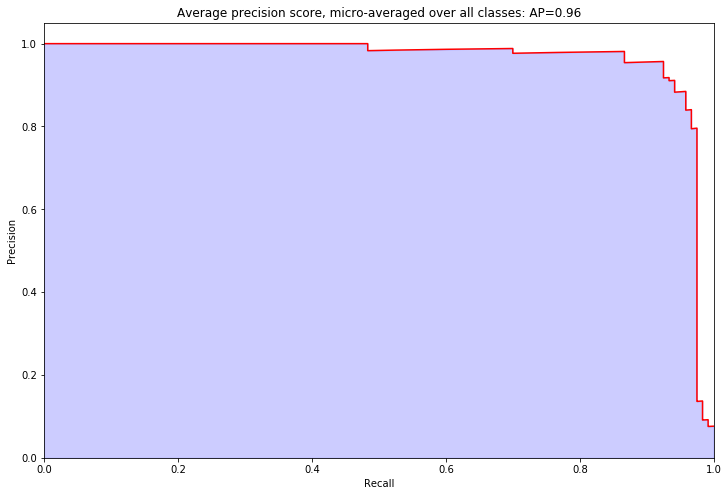

In [30]:
# 绘制p-r曲线
plt.figure(1, figsize=(12,8))
plt.plot(recall['micro'], precision['micro'], color='r')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

Pipeline的使用示例

In [32]:
from sklearn.pipeline import Pipeline
work_flows_std = list()
work_flows_std.append(('pca', PCA(n_components=select_n_conponents,whiten=True,random_state=78)))
work_flows_std.append(('logReg', gridsearchCV.best_estimator_))
model_std = Pipeline(work_flows_std)

model_std.fit(x_train, y_train)
y_pred=model_std.predict(x_test)

print("Accuracy score:{:.2f}".format(accuracy_score(y_test, y_pred)))
print("Classification Results:\n{}".format(classification_report(y_test, y_pred)))


Accuracy score:0.95
Classification Results:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.75      1.00      0.86         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      0.67    